# Hydroshare Graph Explorer

Exploring the hydroshare graph leveraging off the wowk at https://derwen.ai/docs/kgl/ex6_1/


In [15]:
import kglab
from os.path import dirname
import os
import igraph as ig
import leidenalg as la
from networkx.algorithms import bipartite
import networkx as nx

In [2]:
ns = {
    "nom":  "http://example.org/#",
    "schema" : "https://schema.org/",
    "hydroshare": "https://www.hydroshare.org/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
    "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
}

kg = kglab.KnowledgeGraph(
    name = "Hydroshare graph Sept 23rd 2021",
    base_uri = "https://www.hydroshare.org/",
    namespaces = ns,
    use_gpus=False   ## Need to turn off GPU here due to 
)

kg.load_rdf("./data/hydroshare_graph.ttl")

In [3]:
testnamespaces = {
    "nom":  "http://example.org/#",
    "wtm":  "http://purl.org/heals/food/",
    "ind":  "http://purl.org/heals/ingredient/",
    "skos": "http://www.w3.org/2004/02/skos/core#",
}

testkg = kglab.KnowledgeGraph(
    name = "A recipe KG example based on Food.com",
    base_uri = "https://www.food.com/recipe/",
    namespaces = testnamespaces,
    use_gpus=False
)

testkg.load_rdf("./data/recipes.ttl") ;

In [4]:
# ?s rdf:type <https://schema.org/Dataset>  .

testsparql = """
    SELECT ?subject ?object
    WHERE {
        ?subject rdf:type wtm:Recipe .
        ?subject wtm:hasIngredient ?object .
    }
    """

sparql = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT *
  WHERE {
      ?s ?p ?o 
  }
"""

sparql2 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>

SELECT ?subject ?object
  WHERE {
      ?subject rdf:type schema:Dataset  .
      ?subject schema:keywords ?object .
  }
  LIMIT 14000
"""

sparql2v2 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX schema: <https://schema.org/>

SELECT ?subject ?object
  WHERE {
      ?s rdf:type schema:Dataset  .
       FILTER isIRI(?s)
      ?s schema:url ?subject  .
      ?s schema:keywords ?object .
  }
  """

sparql3 = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>

SELECT ?s ?p ?o
  WHERE {
      BIND (<https://www.hydroshare.org/resource/aefabd0a6d7d47ebaa32e2fb293c9f8a#schemaorg> AS ?s)
      ?s ?p ?o
  }
  """

## Review
Let's take a look at one our resources to get a feel for the data in a record

In [35]:
dfres = kg.query_as_df(sparql3,  bindings=None, simplify=False, pythonify=False)
dfres.head(len(dfres))

s  \
0   https://www.hydroshare.org/resource/aefabd0a6d...   
1   https://www.hydroshare.org/resource/aefabd0a6d...   
2   https://www.hydroshare.org/resource/aefabd0a6d...   
3   https://www.hydroshare.org/resource/aefabd0a6d...   
4   https://www.hydroshare.org/resource/aefabd0a6d...   
5   https://www.hydroshare.org/resource/aefabd0a6d...   
6   https://www.hydroshare.org/resource/aefabd0a6d...   
7   https://www.hydroshare.org/resource/aefabd0a6d...   
8   https://www.hydroshare.org/resource/aefabd0a6d...   
9   https://www.hydroshare.org/resource/aefabd0a6d...   
10  https://www.hydroshare.org/resource/aefabd0a6d...   
11  https://www.hydroshare.org/resource/aefabd0a6d...   
12  https://www.hydroshare.org/resource/aefabd0a6d...   
13  https://www.hydroshare.org/resource/aefabd0a6d...   
14  https://www.hydroshare.org/resource/aefabd0a6d...   
15  https://www.hydroshare.org/resource/aefabd0a6d...   
16  https://www.hydroshare.org/resource/aefabd0a6d...   
17  https://www.hydroshare.org/resource/aefabd0a6d...   
18  https://www.hydroshare.org/resource/aefabd0a6d...   
19  https://www.hydroshare.org/resource/aefabd0a6d...   
20  https://www.hydroshare.org/resource/aefabd0a6d...   
21  https://www.hydroshare.org/resource/aefabd0a6d...   

                                                  p  \
0   http://www.w3.org/1999/02/22-rdf-syntax-ns#type   
1                 https://schema.org/additionalType   
2             https://schema.org/creativeWorkStatus   
3                        https://schema.org/creator   
4                    https://schema.org/dateCreated   
5                   https://schema.org/dateModified   
6                    https://schema.org/description   
7                   https://schema.org/distribution   
8                         https://schema.org/funder   
9                     https://schema.org/identifier   
10                    https://schema.org/inLanguage   
11         https://schema.org/includedInDataCatalog   
12           https://schema.org/isAccessibleForFree   
13                      https://schema.org/keywords   
14                      https://schema.org/keywords   
15                       https://schema.org/license   
16                          https://schema.org/name   
17                      https://schema.org/provider   
18               https://schema.org/spatialCoverage   
19                     https://schema.org/subjectOf   
20              https://schema.org/temporalCoverage   
21                           https://schema.org/url   

                                                    o  
0                          https://schema.org/Dataset  
1   http://www.hydroshare.org/terms/CompositeResource  
2                                              Public  
3             n7a8720c664da401d9a09e70f976a361fb42285  
4                    2020-04-30T14:34:56.820098+00:00  
5                    2020-05-26T16:52:38.118089+00:00  
6   In 2018, surveys were conducted with residents...  
7             n7a8720c664da401d9a09e70f976a361fb42287  
8             n7a8720c664da401d9a09e70f976a361fb42288  
9   https://www.hydroshare.org/resource/aefabd0a6d...  
10                                              en-US  
11            n7a8720c664da401d9a09e70f976a361fb42289  
12                                               true  
13                                        Water reuse  
14                                        survey data  
15            n7a8720c664da401d9a09e70f976a361fb42290  
16           Hyrum-Logan Utah Water Reuse Survey Data  
17                         https://www.hydroshare.org  
18            n7a8720c664da401d9a09e70f976a361fb42291  
19            n7a8720c664da401d9a09e70f976a361fb42293  
20                              2018-05-05/2018-06-30  
21  https://www.hydroshare.org/resource/aefabd0a6d...

In [36]:
import pandas as pd
# pd.set_option("max_rows", None)

df = kg.query_as_df(sparql2v2,  bindings=None, simplify=False, pythonify=False)
df.object = df.object.str.strip('"')
df.head()

subject                    object
0  https://doi.org/10.4211/hs.00dda61694e94943995...    erosion and deposition
1  https://doi.org/10.4211/hs.00dda61694e94943995...           hyporheic flows
2  https://doi.org/10.4211/hs.00dda61694e94943995...                     scour
3  https://doi.org/10.4211/hs.00dda61694e94943995...  stream water temperature
4  https://doi.org/10.4211/hs.00f984c69af54b4fbb5...        Seawater intrusion

In [37]:
df.value_counts("object")

object
model-my-watershed                                   566
mmw                                                  566
cbf                                                  276
USACE Corps Water Management System (CWMS)           251
Pequea                                               234
                                                    ... 
Remote Sense                                           1
Reliability theory                                     1
Reliability Analysis                                   1
Relation between flooded areas and storage volume      1
δ15N; Stable N Isotopes                                1
Length: 7307, dtype: int64

In [38]:
subgraph = kglab.SubgraphMatrix(kg, sparql2v2)
ig_graph = subgraph.build_ig_graph(ig.Graph())

In [39]:
count = ig_graph.vcount()
sample = ig_graph.vs[1000].attributes()

print("Found {} with a sample looking like {}".format(count, sample))

Found 63102 with a sample looking like {'name': 'https://doi.org/10.4211/hs.aae061ed6ab345818ceacd61fa644679', 'label': 'https://doi.org/10.4211/hs.aae061ed6ab345818ceacd61fa644679'}


In [40]:
# save out if you want to
with open("tmp.graphml", "w") as f:
    ig_graph.write_graphml(f)

## Community detection

In [11]:
component = ig_graph.components().subgraph(0)
partition = la.find_partition(component, la.ModularityVertexPartition)

In [12]:
# do not try..   memory issues
# ig.plot(partition, bbox=(800, 600), vertex_label_size=0, margin=50)


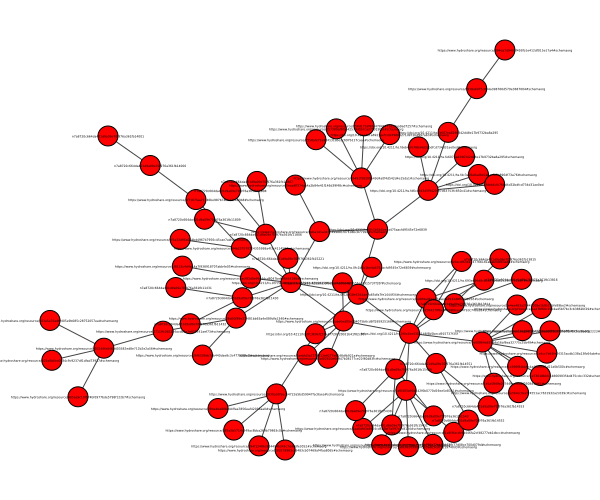

In [13]:
ig.plot(partition.subgraph(40), bbox=(600, 500), vertex_label_size=3, margin=50)

## NetworkX exploring

Look at:  https://derwen.ai/docs/kgl/ex6_0/

In [44]:
nx_graph = subgraph.build_nx_graph(nx.DiGraph(), bipartite=True)

In [45]:
nx.density(nx_graph)

0.00016339091253780565

In [47]:
# butter_node = kg.get_keyset("https://schema.org/Dataset")
bi = subgraph.transform("https://doi.org/10.4211/hs.aae061ed6ab345818ceacd61fa644679")

edges = list(nx.bfs_edges(nx_graph, source=bi, depth_limit=2))
print("num edges:", len(edges))

NetworkXError: The node 12601 is not in the digraph.